In [1]:
import numpy as np
import pandas as pd
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate
from autogluon.tabular import TabularDataset, TabularPredictor
import time

import toolsets.feature_engineering as fe
import toolsets.data_prep as data_prep
import toolsets.auto_rt_pred as ap
import seaborn as sns
from tqdm import tqdm
import toolsets.spectra_operations as so
%load_ext autoreload
%autoreload 2
import toolsets.helpers as helper

i am updated!
Compile the cython code is highly recommended!


# below cell is for preprocessing

In [2]:
data_binbase = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/bins_shen_hilic_pos_neg_nist.csv")
data_original = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/bins_shen_hilic_pos_neg.csv")
data = helper.pick_results(data_binbase, data_original,lowest_entropy_allowed = 0.5)
data = helper.get_smiles(data)
data = helper.get_class(data)
data = data[~data['SMILES'].isnull()]

100%|██████████| 350/350 [00:31<00:00, 11.10it/s]


In [43]:
# data = pd.read_csv("data/lcbinbase/pdata_hilic_5m_orbitrap_beh_pos_neg.csv")


In [4]:
start = time.time()
descriptors_table = helper.make_descriptors(data)
end = time.time()

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: 

In [5]:
print((end-start)/60)

3.6067447503407797


In [74]:
# features_all= fe.descriptors_prep(descriptors_table)

In [30]:
descriptors_table_complete = fe.descriptors_prep(descriptors_table, ifconcat=False)

In [86]:
features_complete = pd.DataFrame()
for index, row in data.iterrows():
    # print(row['SMILES'])
    temp = descriptors_table_complete.loc[descriptors_table_complete['SMILES'] == row['SMILES']]
    features_complete = pd.concat([features_complete, temp], axis=0)
    # break
features_complete = features_complete.drop(['SMILES'], axis=1)
features_complete.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True, drop=True)
data_hilic = pd.concat([data['retention_time'],data['comments'],data['SMILES'],features_complete], axis=1)

In [89]:
data_hilic.loc[data_hilic['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']

,retention_time,comments,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,9.545269,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
30,34.647135,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
54,79.434094,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
177,74.719501,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
456,14.547311,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
509,14.105863,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
574,14.454435,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
596,14.558808,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
611,29.551713,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667
655,14.298367,5m hilic | orbitrap | beh amide | negative,CC1=CC=C(C=C1)OS(=O)(=O)O,9.071427,8.261492,1,0,13.796637,2.262442,4.524884,...,9.089866,42.369147,188.01433,9.400716,207,12,58.0,61.0,5.534722,2.541667


In [90]:
# data_hilic=data_hilic[data_hilic['comments'].isin(['5m hilic | orbitrap | beh amide | negative', '5m hilic | orbitrap | beh amide | positive']) ]

<AxesSubplot:xlabel='retention_time', ylabel='Count'>

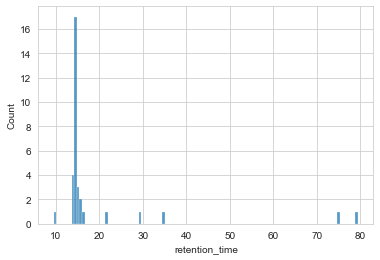

In [99]:
# sns.histplot(data_hilic.loc[data_hilic['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']['retention_time'])

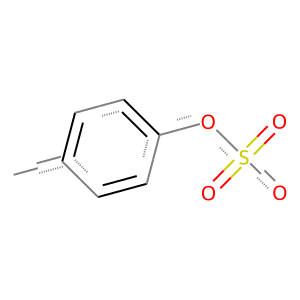

In [161]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolToImage(Chem.MolFromSmarts('CC1=CC=C(C=C1)OS(=O)(=O)O'), molsPerRow=6, subImgSize=(180, 180))

In [ ]:
data_hilic['comments'].value_counts()

In [96]:
len(data_hilic['SMILES'].unique())

350

In [26]:
# features_complete= features_complete.drop(['SMILES'], axis = 1)

In [117]:
data_hilic_confirmed = fe.mislable_exclusion(data_hilic, 'comments',features_complete.columns, 0.05)

k-fold: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


In [118]:
unique_smiles = data_hilic_confirmed['SMILES'].unique()
# team1 =  set(random.sample(all_players, 6))
# team2 = all_players - team1

In [122]:
from sklearn.model_selection import train_test_split

In [137]:
X1, X2 = train_test_split(unique_smiles, test_size=0.2)

In [ ]:
data_hilic_confirmed

In [145]:
data_hilic_model = pd.concat([data_hilic_confirmed['SMILES'], data_hilic_confirmed['retention_time'], data_hilic_confirmed[feature_importance.index[0:100]]], axis=1)

In [149]:
train = data_hilic_model[data_hilic_model['SMILES'].isin(X1)]
train = train.drop(['SMILES'], axis=1)

In [150]:
test = data_hilic_model[~data_hilic_model['SMILES'].isin(X1)]
test = test.drop(['SMILES'], axis=1)

In [151]:
ap.autogluon_fit_train_test(train,test, "subset_by_compounds")

Beginning AutoGluon training ...
AutoGluon will save models to "subset_by_compounds/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    856
Train Data Columns: 100
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.40302041275078, 0.0563704715822627, 61.5696, 40.2796)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4891.47 MB
	Train Data (Original)  Memory Usage: 0.68 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set featur

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        NeuralNetTorch -13.399883       0.033879  26.215434                0.033879          26.215434            1       True          9
1   WeightedEnsemble_L2 -13.399883       0.034024  26.304160                0.000145           0.088726            2       True         11
2         LightGBMLarge -15.226330       0.003202  20.172023                0.003202          20.172023            1       True         10
3            LightGBMXT -15.356639       0.006837   9.031007                0.006837           9.031007            1       True          3
4               XGBoost -15.467186       0.007888  10.741487                0.007888          10.741487            1       True          8
5         ExtraTreesMSE -15.608342       0.019951   0.280854                0.019951           0.280854 

In [140]:
len(train['SMILES'].unique())

262

In [141]:
len(test['SMILES'].unique())

66

In [ ]:
data_hilic_confirmed.unique()

In [160]:
data.loc[data['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']

,score,notes,instrument_type,comments,splash,precursormz,normalized_entropy,library_inchi,library_adduct,retention_time,entropy,msms,SMILES,classes
0,0.933503,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2900000000-e2d4228d01eb088edb4c,187.006927,0.585092,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,9.545269,0.642789,48.0717\t450267.34\n51.3891\t393197.50\n75.133...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
30,0.932428,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-aeebd4cee644bd147192,187.006866,0.565701,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,34.647135,0.621487,55.1675\t330214.91\n67.8168\t299470.78\n79.957...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
54,0.934037,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2910000000-ac641457b7f3075f4ca1,187.006927,0.591873,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,79.434094,0.650239,43.4719\t658597.44\n55.5859\t641756.81\n56.126...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
177,0.934291,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2910000000-18c1d343e27d24d1c6a7,187.006882,0.592024,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,74.719501,0.650404,52.2323\t588410.38\n79.0183\t417944.53\n79.951...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
456,0.932785,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-1c9fd20dfbcd8728612a,187.006864,0.570274,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.547311,0.626510,43.3349\t486107.50\n43.6135\t447452.19\n46.735...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
509,0.933005,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1910000000-ffe04d0521840fd1223f,187.006784,0.573083,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.105863,0.629596,42.3112\t517835.06\n43.1106\t520013.22\n43.433...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
574,0.932851,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-4dce8a6c5dcc87c01aa3,187.006842,0.572360,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.454435,0.628802,42.5661\t144546.91\n43.6628\t202596.81\n44.310...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
596,0.933147,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2910000000-a3f765faa32975203647,187.006780,0.573399,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.558808,0.629944,42.8277\t194166.72\n43.2109\t299930.00\n44.472...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
611,0.932969,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-758349a6f2f269950d15,187.006783,0.577678,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,29.551713,0.634644,42.5099\t52389.02\n42.6955\t173123.20\n43.6369...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
655,0.932845,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1910000000-312f4f8aba73f9e6cf12,187.006812,0.571618,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.298367,0.627986,42.6404\t441127.31\n42.9252\t283932.63\n43.235...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives


<AxesSubplot:xlabel='retention_time', ylabel='Count'>

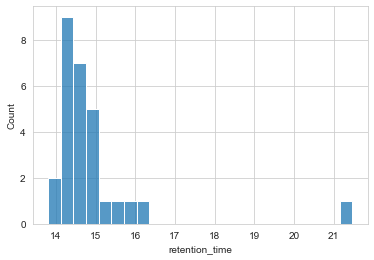

In [106]:
sns.histplot(data_hilic_confirmed.loc[data_hilic_confirmed['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']['retention_time'])

In [74]:
len(data['SMILES'].unique())

350

In [61]:
data_hilic_confirmed.head()

,retention_time,comments,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
9,21.158951,5m hilic | orbitrap | beh amide | negative,13.202929,11.709699,0,0,20.712705,2.383498,4.742568,20.712705,...,9.663770,63.242131,253.052112,9.037575,535,22,88.0,100.0,6.506944,3.625000
11,21.852032,5m hilic | orbitrap | beh amide | negative,16.258866,13.992746,1,0,27.060767,2.570531,5.010168,27.060767,...,10.236633,69.916593,287.152144,6.836956,825,38,114.0,140.0,7.229167,4.736111
15,24.013674,5m hilic | orbitrap | beh amide | negative,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,...,9.931443,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889
16,24.013674,5m hilic | orbitrap | beh amide | negative,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,...,9.931443,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889
17,24.218681,5m hilic | orbitrap | beh amide | negative,14.470305,11.689063,1,0,25.010365,2.051411,4.102821,25.010365,...,8.687948,51.656682,296.235145,5.589342,1452,19,82.0,81.0,7.972222,5.250000


In [51]:
print("the length of the original dataset is: ", len(data_hilic))
print("the length of the new dataset is :", len(data_hilic_confirmed))

the length of the original dataset is:  1207
the length of the new dataset is : 819


In [94]:
# descriptors = pd.DataFrame()
# for index, row in data.iterrows():
#     # print(row['SMILES'])
#     temp = features_complete.loc[features_complete['SMILES'] == row['SMILES']]
#     descriptors = pd.concat([descriptors, temp], axis=0)
#     # break
# descriptors = descriptors.drop(['SMILES'], axis=1)
# descriptors.reset_index(inplace=True, drop=True)
# data.reset_index(inplace=True, drop=True)
# data_hilic = pd.concat([data['retention_time'],descriptors], axis=1)

In [52]:
data_hilic_confirmed=data_hilic_confirmed.drop(['comments'], axis = 1)

In [53]:
train, test = data_prep.make_train_test(data_hilic_confirmed)
ap.autogluon_fit_train_test(train,test, "confirmed_0.16")

Beginning AutoGluon training ...
AutoGluon will save models to "confirmed_0.16/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    650
Train Data Columns: 1224
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (142.92571346409505, 10.356760991096657, 66.09326, 40.78709)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5209.6 MB
	Train Data (Original)  Memory Usage: 6.36 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_m

[1000]	valid_set's rmse: 10.2087
[2000]	valid_set's rmse: 10.2021
[3000]	valid_set's rmse: 10.199
[4000]	valid_set's rmse: 10.1985
[5000]	valid_set's rmse: 10.1985
[6000]	valid_set's rmse: 10.1985
[7000]	valid_set's rmse: 10.1985
[8000]	valid_set's rmse: 10.1985
[9000]	valid_set's rmse: 10.1985
[10000]	valid_set's rmse: 10.1985


	-10.1985	 = Validation score   (root_mean_squared_error)
	233.15s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-10.807	 = Validation score   (root_mean_squared_error)
	3.47s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...
	-10.1121	 = Validation score   (root_mean_squared_error)
	15.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-10.0834	 = Validation score   (root_mean_squared_error)
	1.43s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
		Import fastai failed. A quick tip is to install via `pip install fastai==2.*`. If you are using Mac OSX, please use this torch version to avoid compatibility issues: `pip install torch==1.6.0`.
Fitting model: XGBoost ...
	-9.7377	 = Validation score   (root_mean_squared_error)
	14.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.9122	 = Validation score  

[1000]	valid_set's rmse: 10.1111
[2000]	valid_set's rmse: 10.1073
[3000]	valid_set's rmse: 10.1073
[4000]	valid_set's rmse: 10.1073
[5000]	valid_set's rmse: 10.1073


	-10.1073	 = Validation score   (root_mean_squared_error)
	465.67s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-8.5502	 = Validation score   (root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 781.21s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("confirmed_0.16/")


*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -8.550169       0.116906   58.549022                0.000178           0.103130            2       True         11
1        NeuralNetTorch  -8.912222       0.105210   31.591519                0.105210          31.591519            1       True          9
2            LightGBMXT  -9.050426       0.005904   12.216214                0.005904          12.216214            1       True          3
3               XGBoost  -9.737727       0.005614   14.638159                0.005614          14.638159            1       True          8
4         ExtraTreesMSE -10.083395       0.023428    1.432884                0.023428           1.432884            1       True          7
5         LightGBMLarge -10.107289       0.114995  465.672364                0.114995         465.

Evaluation: root_mean_squared_error on test data: -9.9199619396618
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -9.9199619396618,
    "mean_squared_error": -98.40564488433871,
    "mean_absolute_error": -6.739712097290864,
    "r2": 0.9414799488280364,
    "pearsonr": 0.9703736392987464,
    "median_absolute_error": -4.494949494845873
}


{'root_mean_squared_error': -9.9199619396618, 'mean_squared_error': -98.40564488433871, 'mean_absolute_error': -6.739712097290864, 'r2': 0.9414799488280364, 'pearsonr': 0.9703736392987464, 'median_absolute_error': -4.494949494845873}


In [107]:
train, test = data_prep.make_train_test(data_hilic)
ap.autogluon_fit_train_test(train,test, "all_features")

Beginning AutoGluon training ...
AutoGluon will save models to "all_features/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    955
Train Data Columns: 1512
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (196.96833749042693, 0.0563704715822627, 66.50801, 44.33481)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5097.19 MB
	Train Data (Original)  Memory Usage: 10.45 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_m

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -28.285040       0.055435  32.692655                0.000147           0.088039            2       True         11
1            LightGBMXT -28.382413       0.005593  15.394011                0.005593          15.394011            1       True          3
2              LightGBM -28.722768       0.005069  17.126163                0.005069          17.126163            1       True          4
3              CatBoost -28.962303       0.025101  24.283799                0.025101          24.283799            1       True          6
4               XGBoost -29.174195       0.010027  11.153360                0.010027          11.153360            1       True          8
5         ExtraTreesMSE -29.344218       0.022997   2.051186                0.022997           2.051186 

Evaluation: root_mean_squared_error on test data: -29.270446139488826
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -29.270446139488826,
    "mean_squared_error": -856.7590172047163,
    "mean_absolute_error": -17.713998976061472,
    "r2": 0.6128480548610689,
    "pearsonr": 0.785008968922323,
    "median_absolute_error": -7.651427088065702
}


{'root_mean_squared_error': -29.270446139488826, 'mean_squared_error': -856.7590172047163, 'mean_absolute_error': -17.713998976061472, 'r2': 0.6128480548610689, 'pearsonr': 0.785008968922323, 'median_absolute_error': -7.651427088065702}


In [79]:
from toolsets import classyfire

In [20]:
import toolsets.ms2_spectra_plotter as ms2plotter

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [48]:
# data_temp_include = data_temp.loc[data_temp['retention_time'].between(left_bound, right_bound, inclusive="both")]
# data_temp_exclude = data_temp.loc[~data_temp['retention_time'].between(left_bound, right_bound, inclusive="both")]

In [56]:
data_temp_include['retention_time'].describe()

count    25.000000
mean     15.943033
std       5.224142
min       9.545269
25%      14.324961
50%      14.454435
75%      14.759411
max      34.647135
Name: retention_time, dtype: float64

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

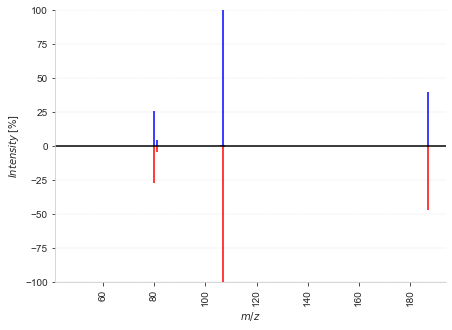

In [62]:
ms2plotter.head_to_tail_plot(data_temp_include.iloc[0]['msms'],data_temp_exclude.iloc[1]['msms'])

In [323]:
data_hilic = pd.concat([data['retention_time'],descriptors_imputed], axis=1)

In [59]:
data_hilic_confirmed

,retention_time,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,split_index
0,21.158951,13.202929,11.709699,0,0,20.712705,2.383498,4.742568,20.712705,1.218394,...,63.242131,253.052112,9.037575,535,22,88.0,100.0,6.506944,3.625000,1
1,21.852032,16.258866,13.992746,1,0,27.060767,2.570531,5.010168,27.060767,1.288608,...,69.916593,287.152144,6.836956,825,38,114.0,140.0,7.229167,4.736111,2
2,24.013674,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,1.219089,...,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889,1
3,24.013674,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,1.219089,...,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889,2
4,24.218681,14.470305,11.689063,1,0,25.010365,2.051411,4.102821,25.010365,1.190970,...,51.656682,296.235145,5.589342,1452,19,82.0,81.0,7.972222,5.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,126.192690,11.510585,10.996419,1,1,17.319018,2.230897,4.461795,17.319018,1.082439,...,47.240747,257.102824,7.141745,522,16,72.0,73.0,8.736111,3.541667,1
815,35.969883,8.485281,8.852607,0,1,15.575479,2.257545,4.515089,15.575479,1.198114,...,42.702008,186.221626,4.541991,284,16,52.0,56.0,6.062500,3.500000,1
816,126.262252,11.510585,10.996419,1,1,17.319018,2.230897,4.461795,17.319018,1.082439,...,47.240747,257.102824,7.141745,522,16,72.0,73.0,8.736111,3.541667,1
817,117.585112,6.163363,6.515899,1,3,9.335326,2.116883,4.233766,9.335326,1.037258,...,36.359125,131.069477,7.281638,96,8,36.0,36.0,5.583333,2.111111,2


In [ ]:
data_temp

In [324]:
train, test = data_prep.make_train_test(data_hilic)
ap.autogluon_fit_train_test(train,test, "seconds")

In [ ]:
# filter only query normalized entropy >0.5

In [328]:
from autogluon.tabular import TabularPredictor

In [54]:
model = TabularPredictor.load("confirmed_0.16")

In [108]:
# feature_importance = model.feature_importance(test)

These features in provided data are not utilized by the predictor and will be ignored: ['nB', 'nI', 'C2SP1', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NtCH', 'NddC', 'NssNH2', 'NsssNH', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NsssssP', 'NsSH', 'NdS', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'NsssssAs', 'NsSeH', 'NdSe', 'NssSe', 'NaaSe', 'NdssSe', 'NddssSe', 'NsSnH3', 'NssSnH2', 'NsssSnH', 'NssssSn', 'NsI', 'NsPbH3', 'NssPbH2', 'NsssPbH', 'NssssPb', 'SsLi', 'SssBe', 'SssssBe', 'SssBH', 'SsssB', 'SssssB', 'StCH', 'SddC', 'SssNH2', 'SsssNH', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SsssssP', 'SsSH', 'SdS', 'SsGeH3', 'SssGeH2', 'SsssGeH', 'SssssGe', 'SsAsH2', 'SssAsH', 'SsssAs', 'SsssdAs', 'SsssssAs', 'SsSeH', 'SdSe', 'SssSe', 'SaaSe', 'SdssSe', 'SddssSe', 'SsSnH3', 'SssSnH2', 'SsssSnH', 'SssssSn', 'SsI', 'SsPbH3', 'SssPbH2', 'SsssPbH', 'SssssPb', 'ETA_dPsi_B', 'SMR_VSA8',

In [114]:
# data_hilic_confirmed[feature_importance.index[0:100]]

,AATS4i,Mi,AATS0i,AATSC2d,PEOE_VSA1,PEOE_VSA6,nBase,SLogP,AATS1i,NssO,...,nS,SaaN,nO,MATS1pe,ATSC1dv,NsCH3,NaasC,NaaN,SMR_VSA6,SlogP_VSA11
0,159.976945,1.110915,157.817119,-0.178209,9.843390,11.600940,0,3.81300,142.030001,1,...,0,0.000000,4,-0.047112,48.767182,2,4,0,0.000000,5.749512
1,165.757330,1.132304,164.265771,-0.087413,10.256762,5.156663,0,1.36602,150.023927,0,...,1,3.554049,3,-0.010733,8.437642,1,4,1,10.455762,0.000000
2,155.834793,1.125701,162.056397,0.128118,14.827369,32.046576,0,3.38300,145.189723,1,...,0,0.000000,3,-0.037565,65.888889,2,3,0,6.606882,0.000000
3,159.976945,1.110915,157.817119,-0.178209,9.843390,11.600940,0,3.81300,142.030001,1,...,0,0.000000,4,-0.047112,48.767182,2,4,0,0.000000,5.749512
4,159.976945,1.110915,157.817119,-0.178209,9.843390,11.600940,0,3.81300,142.030001,1,...,0,0.000000,4,-0.047112,48.767182,2,4,0,0.000000,5.749512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,174.410047,1.156424,170.739620,-0.152585,28.636992,0.000000,1,-1.45260,152.748491,2,...,0,0.000000,6,-0.238196,-18.865379,3,0,0,47.508418,0.000000
815,162.212684,1.148897,168.547966,-0.063103,4.483031,19.765380,1,3.44320,148.910487,0,...,0,0.000000,0,0.185914,13.511005,4,0,0,26.179026,0.000000
816,174.410047,1.156424,170.739620,-0.152585,28.636992,0.000000,1,-1.45260,152.748491,2,...,0,0.000000,6,-0.238196,-18.865379,3,0,0,47.508418,0.000000
817,176.167274,1.175544,176.447725,-0.186372,15.740105,0.000000,3,-1.10373,164.440768,0,...,0,0.000000,2,-0.262522,16.987654,1,0,0,13.592428,0.000000


In [277]:
x_train=train.drop(['retention_time'], axis=1)
y_train = train['retention_time']

In [152]:
x_test = test.drop(['retention_time'], axis=1)
y_test = test['retention_time']

In [154]:
model = TabularPredictor.load('subset_by_compounds')

In [155]:
y_pred = model.predict(x_test)

<AxesSubplot:xlabel='retention_time', ylabel='retention_time'>

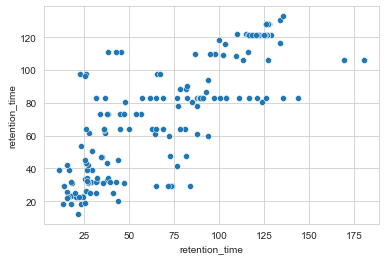

In [156]:
sns.scatterplot(y_test, y_pred)
# sns.scatterplot(y_train, y_train_pred)

In [157]:
import math
MSE = np.square(np.subtract(y_test,y_pred)).mean()

RMSE = math.sqrt(MSE)

In [158]:
print(MSE, RMSE)

454.7100326573845 21.323930985101796
